# Train Triplet Loss Model

Clone this repo and add to system path: http://github.com/adambielski/siamese-triplet

## Imports

In [1]:
import torchvision.datasets as datasets
import numpy as np
import os
import matplotlib.patches as patches
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

from emd import emd

import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
cuda = torch.cuda.is_available()
print(cuda)

True


In [2]:
import sys
sys.path.insert(0, "C:/Grad_School/Code_and_software/Py_code/similarity_scoring/syllable_triplet_network/siamese-triplet-scripts")

In [3]:
# Set up network and training parameters
#from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector, HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector
from metrics import AverageNonzeroTripletsMetric
from datasets import BalancedBatchSampler

In [4]:
from custom_scripts.Therese_auto_mixed_precision_funcs import *
from custom_scripts.Therese_eval_funcs import *
from custom_scripts.Therese_inception_network_blocks import *
from custom_scripts.Therese_training_funcs import *

## Prep Training Data

In [5]:
All_FP1_Birds = ["B145", "B236", "B258", "B385", "B402", "B447", 
             "B507", "G255", "G397", "G402", "G413", "G437", 
             "G439", "G524", "G528", "O144", "O254", "O421", 
             "O440", "O512", "R402", "R425", "R469", "S132", 
             "S421", "S525", "S528", "Y389", "Y397", "Y425", 
             "Y440", "B524", "O434", "S389", "Y433", "Y453"] 

#All_Birds should contain 36 bird IDs. Check: 
len(All_FP1_Birds)

36

In [6]:
all_birds_dir = "C:/Grad_School/Code_and_software/Py_code/Syll_specs_hand_seg_narrow_bandpass_70/"

Bird_ID = "G402"

In [7]:
pairs_df = pd.read_csv("C:/Grad_School/Code_and_software/Py_code/similarity_scoring/tut_pupil_pairs_April_2022.csv")

pairs_df = pairs_df[pairs_df.Include == 1]
pairs_df.head()

,Bird_ID,Tutor_ID,Bird_Condition,Include
0,G402,O314,FP1KD_post_tut,1
1,R402,O314,FP1KD_post_tut,1
2,G555,O314,Baseline,1
3,R629,O314,Baseline,1
4,Y653,O314,Baseline,1


In [8]:
remaining_FP1_birds = set(All_FP1_Birds) - set(pairs_df.Bird_ID)
len(remaining_FP1_birds)

21

In [9]:
to_exclude = set(All_FP1_Birds) & set(pairs_df.Bird_ID)

In [10]:
FP1_pairs_df = pd.read_csv("C:/Grad_School/Code_and_software/Py_code/similarity_scoring/syllable_triplet_network/all_FP1_Tutor_pupil_pairs.csv")

training_pairs_df = FP1_pairs_df[FP1_pairs_df.Bird_ID.isin(remaining_FP1_birds)]

In [11]:
tutor_dict = dict(zip(training_pairs_df.Bird_ID, training_pairs_df.Tutor))

In [12]:
#create test and train datasets
train_dataset = CustomDatasetFolder(all_birds_dir, extensions=(".npy"), loader = np.load, 
                                    train = True, Bird_ID = Bird_ID, exclude = to_exclude)
test_dataset = CustomDatasetFolder(all_birds_dir, extensions = (".npy"), loader = np.load, 
                                    train = False, Bird_ID = Bird_ID)

train_dataset.train_labels = torch.Tensor([label for value, label in train_dataset])
test_dataset.test_labels = torch.Tensor([label for value, label in test_dataset])

### Train Model

In [60]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, 3), nn.ReLU())
        self.MAM1 = InceptionBlock(32, 32, 16, 32, 16, 32, 16, 32)
        self.conv2 = nn.Sequential(nn.Conv2d(128, 64, kernel_size= 3, stride = (2, 1)), nn.ReLU())
        self.MAM2 = InceptionBlock(64, 32, 16, 32, 16, 32, 16, 32)
        self.conv3 = nn.Sequential(nn.Conv2d(128, 64, 3, stride = (2, 1)), nn.ReLU())
        self.MAM3 = InceptionBlock(64, 32, 16, 32, 16, 32, 16, 32)
        self.conv4 = nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, stride = (2, 1)), nn.ReLU())
        self.MAM4 = InceptionBlock(64, 32, 16, 32, 16, 32, 16, 32)
        self.conv5 = nn.Sequential(nn.Conv2d(128, 64, 3, stride = (2, 1)), nn.ReLU())
        
        #self.global_pool = nn.AvgPool2d(kernel_size= ) the global pooling reduces the output to a vector of length 64. 
            #to figure out the kernel size necessary to do that I need to know the dimensions of the input and I currently have no clue what that would be

        self.global_pool = nn.AvgPool2d(kernel_size = (1, 4), stride = 4)

        self.fc = nn.Sequential(nn.Linear(960, 256),
                                nn.ReLU(),
                                 
                                nn.Linear(256, 128),
                                nn.ReLU(),
                                 
                                nn.Linear(128, 8)
                                )


    def forward(self, x):
        x = torch.unsqueeze(x, 1).float()
        x = self.conv1(x)
        x = self.MAM1(x)
        x = self.conv2(x)
        x = self.MAM2(x)
        x = self.conv3(x)
        x = self.MAM3(x)
        x = self.conv4(x)
        x = self.MAM4(x)
        x = self.conv5(x)
    
        x = self.global_pool(x)
        x = x.view(x.size()[0], -1)

        x = self.fc(x)

        x = F.normalize(x, p = 2, dim = 1)
        

        return x
        
    def get_embedding(self, x):
        return self.forward(x)

In [61]:
#create data sampler and loader
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, 45, n_samples = 20)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, len(test_dataset.classes), n_samples = 20)

online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler = train_batch_sampler)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler = test_batch_sampler)

In [128]:
#configure model
embedding_net = EmbeddingNet()
model = embedding_net 
if cuda:
    model.cuda()

n_epochs = 30
margin_selector = MetricThresholdMargin(min_margin = 0.1, max_margin = 0.7, margin_step = 0.2, metric_threshold = 2500)

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = 1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma = 0.1, last_epoch = -1)
log_interval = 50

In [63]:
triplet_selector = NoSibsPropSemihardTripletSelector(margin = margin_selector.current_margin, 
                                                    prop_semihard = 0.75, 
                                                    idx_to_class= train_dataset.idx_to_class, 
                                                    pup_tut_dict=tutor_dict)
loss_fn = OnlineTripletLoss(margin_selector, triplet_selector)

c:\Users\tkoch\anaconda3\envs\pyemd_env\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train: [0/16420 (0%)]	Loss: 0.079087	Average nonzero triplets: 8100.0
Epoch: 1/30. Train set: Average loss: 0.0831	Average nonzero triplets: 7413.277777777777
Epoch: 1/30. Validation set: Average loss: 0.0999	Average nonzero triplets: 1372.6666666666667	 current margin value: 0.1
Train: [0/16420 (0%)]	Loss: 0.077571	Average nonzero triplets: 6740.0
Epoch: 2/30. Train set: Average loss: 0.0782	Average nonzero triplets: 6303.333333333333
Epoch: 2/30. Validation set: Average loss: 0.0593	Average nonzero triplets: 1362.0	 current margin value: 0.1
Train: [0/16420 (0%)]	Loss: 0.079883	Average nonzero triplets: 5967.0
Epoch: 3/30. Train set: Average loss: 0.0772	Average nonzero triplets: 5479.277777777777
Epoch: 3/30. Validation set: Average loss: 0.0772	Average nonzero triplets: 754.3333333333334	 current margin value: 0.1
Train: [0/16420 (0%)]	Loss: 0.079128	Average nonzero triplets: 4332.0
Epoch: 4/30. Train set: Average loss: 0.0765	Average nonzero triplets: 4873.388888888889
Epoch: 4/30

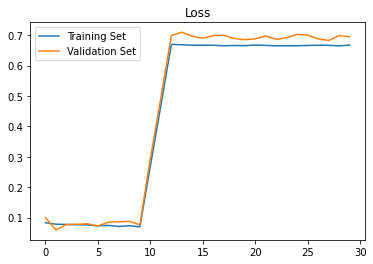

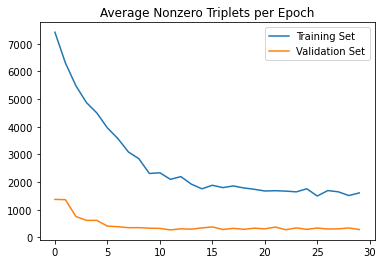

In [64]:
#Fit  the model!
train_losses, val_losses, train_metrics, val_metrics = fit(online_train_loader, online_test_loader, 
                            model, loss_fn, optimizer, scheduler, 
                            n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()], 
                            margin_setter= margin_selector)

#plot losses
plt.plot(train_losses, label = "Training Set" )
plt.plot(val_losses, label = "Validation Set")
plt.title("Loss")
plt.legend()
plt.show()

#plot metrics
plt.plot(train_metrics, label = "Training Set" )
plt.plot(val_metrics, label = "Validation Set")
plt.title("Average Nonzero Triplets per Epoch")
plt.legend()
plt.show()

The jump up in the loss happens because we increase the margin at that point in training. 

The denominator for 'average nonzero triplets per epoch' is the number of triplets per batch. For training, there are 45 classes x 20 samples per batch. together, these can form 900 x (20-1) x (900-20) triplets, which is 15,048,000 total triplets. For validation, there are 8 classes x 20 samples per batch, making 400 x (20-1) x (400-20) triplets = 425,600 triplets. 

This means that in the final epoch, on average across batches, 0.01% of training triplets are non-zero and 0.07% of validation triplets are non-zero. 

In [66]:
torch.save(model, "C:/Grad_School/Code_and_software/Py_code/similarity_scoring/syllable_triplet_network/trained_models/53_emd_July_22_02.pt")

### Calculate EMD

In [67]:
tut_pup_dir = "C:/Grad_School/Code_and_software/Py_code/similarity_scoring/tutor_pupil_dataset/Syll_specs_narrow_bandpass_70/"

In [68]:
import dask
from dask.distributed import Client

In [69]:
dask.config.set({'distributed.scheduler.worker-ttl': (10 * 60)})

In [70]:
client = Client(n_workers=12)

In [71]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 24,Total memory: 31.75 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56185,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 31.75 GiB
Comm: tcp://127.0.0.1:56303,Total threads: 2
Dashboard: http://127.0.0.1:56304/status,Memory: 2.65 GiB
Nanny: tcp://127.0.0.1:56196,


In [72]:
@dask.delayed
def dask_emd(x, y):
    emd_val = emd(x, y)

    return emd_val

In [73]:
all_comparisons = pd.DataFrame()
all_emds_computed = []

n_dim = 8
n_samples = 2000

for n_rows in range(0, 36, 3):
    sub_pairs_df = pairs_df[n_rows : n_rows + 3]

    all_emds = []
    for index, row in sub_pairs_df.iterrows():
        Bird_ID = row.Bird_ID
        Tut_ID = row.Tutor_ID
        print(Bird_ID)

        #compute embedding for current bird
        curr_bird_embedding, curr_bird_labels = single_bird_extract_embeddings(Bird_ID, tut_pup_dir, model, n_dim=n_dim)
        if curr_bird_embedding.shape[0]> n_samples:
            curr_bird_embedding = sample_embedding_rows(curr_bird_embedding, n_samples)

        #compute embedding for current bird's tutor
        curr_tut_embedding, curr_tut_labels = single_bird_extract_embeddings(Tut_ID, tut_pup_dir, model, n_dim=n_dim)
        if curr_tut_embedding.shape[0]> n_samples:
            curr_tut_embedding = sample_embedding_rows(curr_tut_embedding, n_samples)


        #calc emd for tutor-pupil
        emd_val = dask_emd(curr_bird_embedding, curr_tut_embedding)
        all_emds.append(emd_val)

        #record emd in dataframe
        curr_df = pd.DataFrame({"Bird_ID" : [Bird_ID], 
                                "Comparison_Bird_ID" : Tut_ID, 
                                "Tutor_ID" : Tut_ID,  
                                "Same_tut": False, 
                                "Tutor-pupil": True, 
                                "Self_comparison": False})
        all_comparisons = pd.concat([all_comparisons, curr_df])

        print("Tutor Comparison Done")

        #select 3 random birds with a different tutor
        diff_tut = pairs_df[pairs_df.Tutor_ID != Tut_ID]
        diff_tut = diff_tut.sample(n = 3, replace = False)

        #loop over birds with a different tutor
        for sample_idx, diff_tut_row in diff_tut.iterrows():
            diff_tut_Bird_ID = diff_tut_row.Bird_ID
            #compute embedding for comparison bird
            diff_tut_embedding, diff_tut_labels = single_bird_extract_embeddings(diff_tut_Bird_ID, tut_pup_dir, model, n_dim=n_dim)

            if diff_tut_embedding.shape[0]> n_samples:
                diff_tut_embedding = sample_embedding_rows(diff_tut_embedding, n_samples)


            emd_val = dask_emd(diff_tut_embedding, curr_bird_embedding)
            all_emds.append(emd_val)

            curr_df = pd.DataFrame({"Bird_ID" : [Bird_ID], 
                                    "Comparison_Bird_ID" : diff_tut_Bird_ID, 
                                    "Tutor_ID" : Tut_ID, 
                                    "Same_tut": False, 
                                    "Tutor-pupil": False, 
                                    "Self_comparison": False})
            #add emd to dataframe
            all_comparisons = pd.concat([all_comparisons, curr_df])

        print("Diff tutor done")

    all_emds_computed.append(dask.compute(*all_emds))

G402
Tutor Comparison Done
Diff tutor done
R402
Tutor Comparison Done
Diff tutor done
G555
Tutor Comparison Done
Diff tutor done
R629
Tutor Comparison Done
Diff tutor done
Y653
Tutor Comparison Done
Diff tutor done
G587
Tutor Comparison Done
Diff tutor done
B555
Tutor Comparison Done
Diff tutor done
O510
Tutor Comparison Done
Diff tutor done
B447
Tutor Comparison Done
Diff tutor done
S389
Tutor Comparison Done
Diff tutor done
Y389
Tutor Comparison Done
Diff tutor done
O421
Tutor Comparison Done
Diff tutor done
S421
Tutor Comparison Done
Diff tutor done
B402
Tutor Comparison Done
Diff tutor done
Y433
Tutor Comparison Done
Diff tutor done
O434
Tutor Comparison Done
Diff tutor done
R469
Tutor Comparison Done
Diff tutor done
S525
Tutor Comparison Done
Diff tutor done
G413
Tutor Comparison Done
Diff tutor done
G528
Tutor Comparison Done
Diff tutor done
S528
Tutor Comparison Done
Diff tutor done
G668
Tutor Comparison Done
Diff tutor done
R509
Tutor Comparison Done
Diff tutor done
Y354
Tutor 

In [74]:
flat_all_emds = [x for xs in all_emds_computed for x in xs]

In [75]:
all_comparisons["EMD"] = flat_all_emds

In [76]:
all_comparisons.to_csv("C:/Grad_School/Code_and_software/Py_code/similarity_scoring/syllable_triplet_network/53_emd_July_22_02.csv")

### Plot Results

In [77]:
all_comparisons["comparison_type"] = "unrelated_pair"
all_comparisons.loc[all_comparisons["Tutor-pupil"], "comparison_type"] = "tutor_pupil_pair"
all_comparisons.loc[all_comparisons["Same_tut"], "comparison_type"] = "same_tutor_pair"
all_comparisons.loc[all_comparisons["Self_comparison"], "comparison_type"] = "self_comparison"

In [78]:
weird_bird_IDs = pairs_df[pairs_df.Bird_Condition == "FP1KD_pre_tut"].Bird_ID
normal_bird_IDs = pairs_df[pairs_df.Bird_Condition != "FP1KD_pre_tut"].Bird_ID

In [79]:
weird_bird_comparisons = all_comparisons[all_comparisons.Bird_ID.isin(weird_bird_IDs)]
normal_bird_comparisons = all_comparisons[all_comparisons.Bird_ID.isin(normal_bird_IDs)]

In [80]:
weird_bird_comparisons.reset_index(inplace = True)
normal_bird_comparisons.reset_index(inplace = True)

Text(0.5, 1.0, 'Pupils Exhibiting Normal Learning')

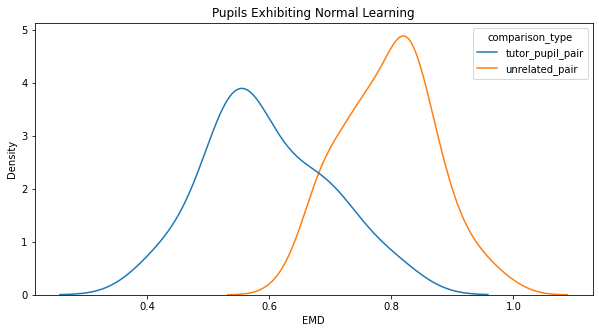

In [81]:
plt.figure(figsize = (10, 5))
sns.kdeplot(data = normal_bird_comparisons, x = 'EMD', hue = 'comparison_type', common_norm = False, )
plt.title("Pupils Exhibiting Normal Learning")

Text(0.5, 1.0, 'Pupils Exhibiting Poor Learning')

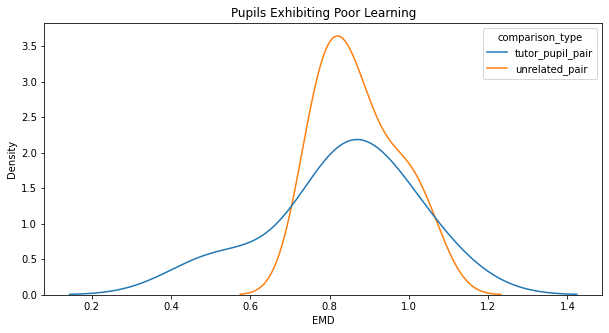

In [82]:
plt.figure(figsize = (10, 5))
sns.kdeplot(data = weird_bird_comparisons, x = 'EMD', hue = 'comparison_type', common_norm = False)
plt.title("Pupils Exhibiting Poor Learning")

In [83]:
normal_bird_comparisons.comparison_type = normal_bird_comparisons.comparison_type.astype("category")
normal_bird_comparisons.comparison_type = normal_bird_comparisons.comparison_type.replace({'tutor_pupil_pair' : "Pupil vs. Tutor", 
                                                        
                                                            'unrelated_pair' : "Pupil vs. Unrelated Bird"})

normal_bird_comparisons.comparison_type = normal_bird_comparisons.comparison_type.astype("category").cat.reorder_categories([
                                                                "Pupil vs. Tutor", 
                                                                
                                                                "Pupil vs. Unrelated Bird"])

C:\Users\tkoch\AppData\Local\Temp\ipykernel_24052\2299760330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_bird_comparisons.comparison_type = normal_bird_comparisons.comparison_type.astype("category")
C:\Users\tkoch\AppData\Local\Temp\ipykernel_24052\2299760330.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_bird_comparisons.comparison_type = normal_bird_comparisons.comparison_type.replace({'tutor_pupil_pair' : "Pupil vs. Tutor",
C:\Users\tkoch\AppData\Local\Temp\ipykernel_24052\2299

In [84]:
weird_bird_comparisons.comparison_type = weird_bird_comparisons.comparison_type.astype("category")
weird_bird_comparisons.comparison_type = weird_bird_comparisons.comparison_type.replace({'tutor_pupil_pair' : "Pupil vs. Tutor", 
                                                        
                                                            'unrelated_pair' : "Pupil vs. Unrelated Bird"})

weird_bird_comparisons.comparison_type = weird_bird_comparisons.comparison_type.astype("category").cat.reorder_categories([
                                                                "Pupil vs. Tutor", 
                                                            
                                                                "Pupil vs. Unrelated Bird"])

C:\Users\tkoch\AppData\Local\Temp\ipykernel_24052\3226570718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weird_bird_comparisons.comparison_type = weird_bird_comparisons.comparison_type.astype("category")
C:\Users\tkoch\AppData\Local\Temp\ipykernel_24052\3226570718.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weird_bird_comparisons.comparison_type = weird_bird_comparisons.comparison_type.replace({'tutor_pupil_pair' : "Pupil vs. Tutor",
C:\Users\tkoch\AppData\Local\Temp\ipykernel_24052\32265707

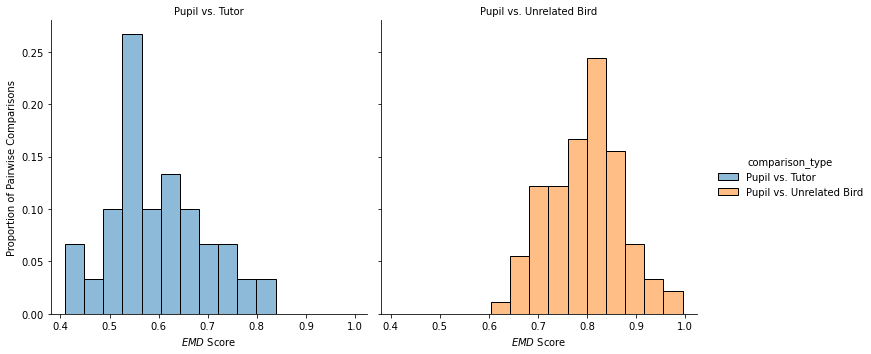

In [85]:
g = sns.displot(normal_bird_comparisons, x = 'EMD', col = 'comparison_type', hue = 'comparison_type', alpha = 0.5,
                 stat = 'probability', common_norm = False, bins = 15)
g.set_axis_labels("$EMD$ Score", "Proportion of Pairwise Comparisons")
g.set_titles("{col_name}")

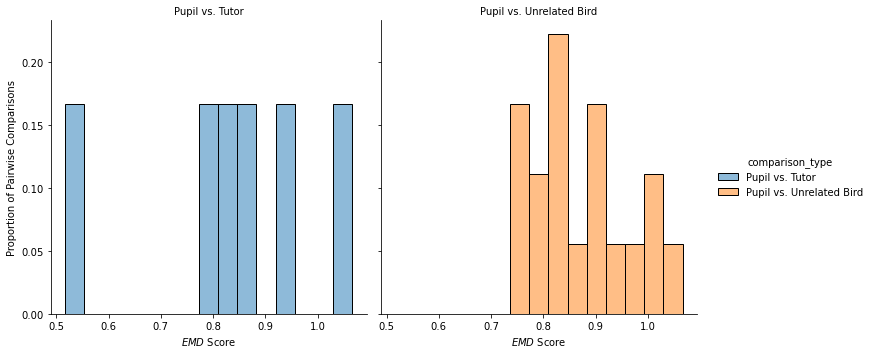

In [86]:
g = sns.displot(weird_bird_comparisons, x = 'EMD', col = 'comparison_type', hue = 'comparison_type', alpha = 0.5,
                 stat = 'probability', common_norm = False, bins = 15)
g.set_axis_labels("$EMD$ Score", "Proportion of Pairwise Comparisons")
g.set_titles("{col_name}")

### Tutor Contrast Index

In [88]:
tut_contrast_index_df = pd.DataFrame()

for Bird_ID in np.unique(normal_bird_comparisons.Bird_ID):
    tut_similarity = normal_bird_comparisons[(normal_bird_comparisons.Bird_ID == Bird_ID) & (normal_bird_comparisons.comparison_type == "Pupil vs. Tutor")].EMD.values
    cross_similarity = normal_bird_comparisons[(normal_bird_comparisons.Bird_ID == Bird_ID) & (normal_bird_comparisons.comparison_type == "Pupil vs. Unrelated Bird")].EMD.values

    contrast_index = (cross_similarity - tut_similarity) / (tut_similarity + cross_similarity)
    curr_df = pd.DataFrame({"Bird_ID": Bird_ID, 
                            "tut_similarity" : [tut_similarity[0]], 
                            "cross_similarity" : [cross_similarity[0]], 
                            "contrast_index" : [contrast_index[0]]})
    
    tut_contrast_index_df = pd.concat([tut_contrast_index_df, curr_df])

(array([1., 0., 0., 4., 4., 4., 5., 6., 2., 4.]),
 array([-0.12103807, -0.07830725, -0.03557644,  0.00715438,  0.0498852 ,
         0.09261602,  0.13534683,  0.17807765,  0.22080847,  0.26353929,
         0.30627011]),
 <BarContainer object of 10 artists>)

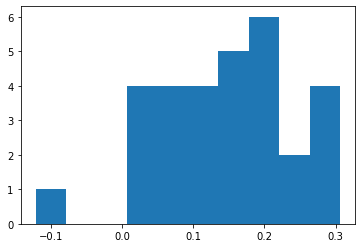

In [89]:
plt.hist(tut_contrast_index_df.contrast_index)

In [90]:
tut_contrast_index_df.contrast_index.median()

0.1451380956931589

In [97]:
client.close()